0
1
2
3
4


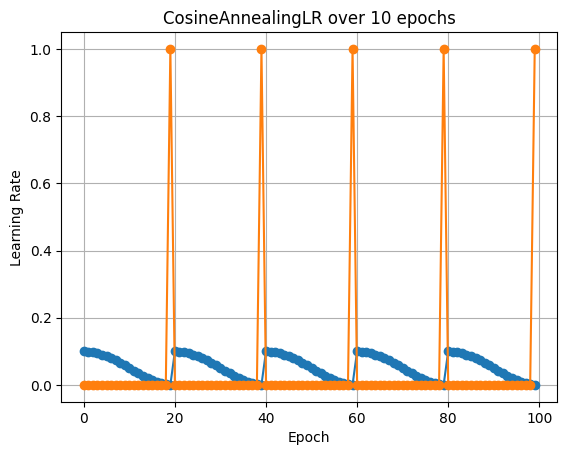

In [14]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

class CyclicLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_0, T, M, last_epoch=-1):
        self.lr_0 = lr_0
        self.T = T
        self.M = M
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        epoch = self.last_epoch // (self.T // self.M)
        batch_idx = self.last_epoch % (self.T // self.M)
        rcounter = epoch * (self.T // self.M) + batch_idx
        cos_inner = np.pi * (rcounter % (self.T // self.M))
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        lr = 0.5 * cos_out * self.lr_0
        return [lr for _ in self.optimizer.param_groups]

# Sample model parameter
epochs = 100
batches = 2
T = epochs
M = 5
model = torch.nn.Linear(10, 2)
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Define the CosineAnnealingLR scheduler

scheduler = CyclicLR(optimizer, 0.1, T, M)

# Store learning rates for each epoch
lrs = []
reds = []

# Simulate 10 epochs
for epoch in range(epochs):
    
    for _ in range(batches):
        optimizer.step()
        
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()
    if epoch%(T//M) == (T//M)-1:
        print(epoch//(T//M))
        reds.append(1)
    else:
        reds.append(0)

        
# Plot the learning rates
plt.plot(range(len(lrs)), lrs, marker='o')
plt.plot(range(len(reds)), reds, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('CosineAnnealingLR over 10 epochs')
plt.grid(True)
plt.show()

In [7]:
import copy
import torch
import torchvision

def flatten_params(model, deepcopy=True):
    if deepcopy: model = copy.deepcopy(model)
    return torch.cat([param.detach().view(-1) for param in model.parameters()])

#weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1
#model = torchvision.models.resnet50(weights=weights)

model = torchvision.models.resnet50()
checkpoint = torch.load('/cluster/home/eharve06/understanding-SWAG/experiments/ImageNet_v1_torchvision_cSGD=batch/ImageNet_v1_torchvision_cSGD=batch_random_state=1001_4.pt')
model.load_state_dict(checkpoint['model'])

model.fc = torch.nn.Identity()

torch.save(flatten_params(model), '/cluster/tufts/hugheslab/eharve06/torchvision-checkpoints/5.pt')


In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=176),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=232),
    torchvision.transforms.CenterCrop(size=224),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = torchvision.datasets.ImageFolder(root='/cluster/tufts/hugheslab/datasets/ImageNet/train/', transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root='/cluster/tufts/hugheslab/datasets/ImageNet/val/', transform=val_transform)

In [371]:
train_subset_indices = torch.randperm(len(train_dataset))[:1000]
train_subset_dataset = torch.utils.data.Subset(train_dataset, train_subset_indices)

In [ ]:
f = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
X = torch.stack([image for image, label in train_subset_dataset])
dist = X.view(X.shape[0], -1)@(-1*X.view(X.shape[0], -1)).t()
y = torch.stack([torch.tensor(label) for image, label in train_subset_dataset])
one_hot_y = torch.nn.functional.one_hot(y, num_classes=1_000)
with torch.no_grad():
    m = f(X)
    
dist, one_hot_y, m = dist.detach().numpy(), one_hot_y.detach().numpy(), m.detach().numpy()

In [370]:
def softplus_np(x): return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def rbf_kernel(dist, ls):
    return np.exp(-(1. / ls / 2) * (dist ** 2))

def neg_MLL(params):
    R, R = dist.shape
    K = rbf_kernel(dist, params[0])
    kernel_term = -(1/2)*(one_hot_y-m).T@np.linalg.inv(K+softplus_np(params[1])*np.eye(R))@(one_hot_y-m)
    logdet = -(1/2)*np.log(np.linalg.det(K+softplus_np(params[1])*np.eye(R)))
    const = -(R/2)*np.log(2*np.pi)
    print(params)
    return -(const + logdet + kernel_term).sum()

from scipy import optimize
learned_hypers = optimize.minimize(neg_MLL, x0=np.array([1e3, 1.0]), tol=1e-100)
learned_hypers

[1000.    1.]
[1.e+03 1.e+00]
[1000.            1.00000001]
[ 1.e+03 -1.e-02]
[ 1.e+03 -1.e-02]
[ 1.0000000e+03 -9.9999851e-03]
[1000.     -4.05]
[1000.00000001   -4.05      ]
[1000.           -4.04999999]
[1000.    -20.21]
[1000.00000001  -20.21      ]
[1000.          -20.20999999]
[1000.    -84.85]
[1000.00000001  -84.85      ]
[1000.          -84.84999999]
[1000.   -343.41]
[1000.00000001 -343.41      ]
[1000.         -343.40999999]


/tmp/ipykernel_225763/926920329.py:10: RuntimeWarning: invalid value encountered in log
  logdet = -(1/2)*np.log(np.linalg.det(K+softplus_np(params[1])*np.eye(R)))
/tmp/ipykernel_225763/926920329.py:10: RuntimeWarning: divide by zero encountered in log
  logdet = -(1/2)*np.log(np.linalg.det(K+softplus_np(params[1])*np.eye(R)))
/cluster/tufts/hugheslabkp/eharve06/miniconda3/envs/bdl-transfer-learning/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


LinAlgError: Singular matrix

In [327]:
R = X.shape[0]
K = rbf_kernel(X, X, 1e3, 1.0)
K

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.3392e-28],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.3392e-28,
         0.0000e+00]])

In [328]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
epochs = 1000
for epoch in range(epochs):
    model.zero_grad()
    loss = model(X, one_hot_y, m)
    loss = torch.clamp(loss, min=1e-20, max=1e20)
    print(loss.item(), model.lengthscale, model.noise, model.outputscale)
    loss.backward()
    optimizer.step()

119145200.0 Parameter containing:
tensor(1000., requires_grad=True) tensor(1.) tensor(1.)
119145200.0 Parameter containing:
tensor(1000.1000, requires_grad=True) tensor(1.) tensor(1.)
119145200.0 Parameter containing:
tensor(1000.2000, requires_grad=True) tensor(1.) tensor(1.)
119145200.0 Parameter containing:
tensor(1000.2999, requires_grad=True) tensor(1.) tensor(1.)
119145200.0 Parameter containing:
tensor(1000.4000, requires_grad=True) tensor(1.) tensor(1.)
119145200.0 Parameter containing:
tensor(1000.5000, requires_grad=True) tensor(1.) tensor(1.)
119145200.0 Parameter containing:
tensor(1000.6000, requires_grad=True) tensor(1.) tensor(1.)
119145200.0 Parameter containing:
tensor(1000.7001, requires_grad=True) tensor(1.) tensor(1.)
119145200.0 Parameter containing:
tensor(1000.8001, requires_grad=True) tensor(1.) tensor(1.)
119145200.0 Parameter containing:
tensor(1000.9001, requires_grad=True) tensor(1.) tensor(1.)
119145200.0 Parameter containing:
tensor(1001.0002, requires_gra

119145184.0 Parameter containing:
tensor(1009.1002, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1009.2029, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1009.3056, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1009.4084, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1009.5112, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1009.6140, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1009.7169, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1009.8198, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1009.9228, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1010.0258, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1010.1288, requires

119145184.0 Parameter containing:
tensor(1018.4927, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1018.5988, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1018.7049, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1018.8110, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1018.9172, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1019.0234, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1019.1296, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1019.2359, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1019.3422, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1019.4485, requires_grad=True) tensor(1.) tensor(1.)
119145184.0 Parameter containing:
tensor(1019.5549, requires

119145176.0 Parameter containing:
tensor(1028.1855, requires_grad=True) tensor(1.) tensor(1.)
119145176.0 Parameter containing:
tensor(1028.2949, requires_grad=True) tensor(1.) tensor(1.)
119145176.0 Parameter containing:
tensor(1028.4043, requires_grad=True) tensor(1.) tensor(1.)
119145176.0 Parameter containing:
tensor(1028.5138, requires_grad=True) tensor(1.) tensor(1.)
119145176.0 Parameter containing:
tensor(1028.6233, requires_grad=True) tensor(1.) tensor(1.)
119145176.0 Parameter containing:
tensor(1028.7328, requires_grad=True) tensor(1.) tensor(1.)
119145176.0 Parameter containing:
tensor(1028.8423, requires_grad=True) tensor(1.) tensor(1.)
119145176.0 Parameter containing:
tensor(1028.9519, requires_grad=True) tensor(1.) tensor(1.)
119145176.0 Parameter containing:
tensor(1029.0615, requires_grad=True) tensor(1.) tensor(1.)
119145176.0 Parameter containing:
tensor(1029.1711, requires_grad=True) tensor(1.) tensor(1.)
119145176.0 Parameter containing:
tensor(1029.2809, requires

119145168.0 Parameter containing:
tensor(1038.1735, requires_grad=True) tensor(1.) tensor(1.)
119145168.0 Parameter containing:
tensor(1038.2861, requires_grad=True) tensor(1.) tensor(1.)
119145168.0 Parameter containing:
tensor(1038.3988, requires_grad=True) tensor(1.) tensor(1.)
119145168.0 Parameter containing:
tensor(1038.5115, requires_grad=True) tensor(1.) tensor(1.)
119145168.0 Parameter containing:
tensor(1038.6241, requires_grad=True) tensor(1.) tensor(1.)
119145168.0 Parameter containing:
tensor(1038.7369, requires_grad=True) tensor(1.) tensor(1.)
119145168.0 Parameter containing:
tensor(1038.8497, requires_grad=True) tensor(1.) tensor(1.)
119145168.0 Parameter containing:
tensor(1038.9625, requires_grad=True) tensor(1.) tensor(1.)
119145168.0 Parameter containing:
tensor(1039.0754, requires_grad=True) tensor(1.) tensor(1.)
119145168.0 Parameter containing:
tensor(1039.1884, requires_grad=True) tensor(1.) tensor(1.)
119145168.0 Parameter containing:
tensor(1039.3013, requires

119145160.0 Parameter containing:
tensor(1048.4497, requires_grad=True) tensor(1.) tensor(1.)
119145160.0 Parameter containing:
tensor(1048.5654, requires_grad=True) tensor(1.) tensor(1.)
119145160.0 Parameter containing:
tensor(1048.6813, requires_grad=True) tensor(1.) tensor(1.)
119145160.0 Parameter containing:
tensor(1048.7971, requires_grad=True) tensor(1.) tensor(1.)
119145160.0 Parameter containing:
tensor(1048.9130, requires_grad=True) tensor(1.) tensor(1.)
119145160.0 Parameter containing:
tensor(1049.0288, requires_grad=True) tensor(1.) tensor(1.)
119145160.0 Parameter containing:
tensor(1049.1448, requires_grad=True) tensor(1.) tensor(1.)
119145160.0 Parameter containing:
tensor(1049.2607, requires_grad=True) tensor(1.) tensor(1.)
119145160.0 Parameter containing:
tensor(1049.3767, requires_grad=True) tensor(1.) tensor(1.)
119145160.0 Parameter containing:
tensor(1049.4928, requires_grad=True) tensor(1.) tensor(1.)
119145160.0 Parameter containing:
tensor(1049.6089, requires

119145152.0 Parameter containing:
tensor(1058.8860, requires_grad=True) tensor(1.) tensor(1.)
119145152.0 Parameter containing:
tensor(1059.0048, requires_grad=True) tensor(1.) tensor(1.)
119145152.0 Parameter containing:
tensor(1059.1235, requires_grad=True) tensor(1.) tensor(1.)
119145152.0 Parameter containing:
tensor(1059.2424, requires_grad=True) tensor(1.) tensor(1.)
119145152.0 Parameter containing:
tensor(1059.3613, requires_grad=True) tensor(1.) tensor(1.)
119145152.0 Parameter containing:
tensor(1059.4802, requires_grad=True) tensor(1.) tensor(1.)
119145152.0 Parameter containing:
tensor(1059.5991, requires_grad=True) tensor(1.) tensor(1.)
119145152.0 Parameter containing:
tensor(1059.7181, requires_grad=True) tensor(1.) tensor(1.)
119145152.0 Parameter containing:
tensor(1059.8372, requires_grad=True) tensor(1.) tensor(1.)
119145152.0 Parameter containing:
tensor(1059.9562, requires_grad=True) tensor(1.) tensor(1.)
119145152.0 Parameter containing:
tensor(1060.0752, requires

119145136.0 Parameter containing:
tensor(1069.5847, requires_grad=True) tensor(1.) tensor(1.)
119145136.0 Parameter containing:
tensor(1069.7064, requires_grad=True) tensor(1.) tensor(1.)
119145136.0 Parameter containing:
tensor(1069.8281, requires_grad=True) tensor(1.) tensor(1.)
119145136.0 Parameter containing:
tensor(1069.9498, requires_grad=True) tensor(1.) tensor(1.)
119145136.0 Parameter containing:
tensor(1070.0715, requires_grad=True) tensor(1.) tensor(1.)
119145128.0 Parameter containing:
tensor(1070.1934, requires_grad=True) tensor(1.) tensor(1.)
119145128.0 Parameter containing:
tensor(1070.3152, requires_grad=True) tensor(1.) tensor(1.)
119145136.0 Parameter containing:
tensor(1070.4370, requires_grad=True) tensor(1.) tensor(1.)
119145136.0 Parameter containing:
tensor(1070.5588, requires_grad=True) tensor(1.) tensor(1.)
119145136.0 Parameter containing:
tensor(1070.6808, requires_grad=True) tensor(1.) tensor(1.)
119145136.0 Parameter containing:
tensor(1070.8027, requires

119145120.0 Parameter containing:
tensor(1080.5339, requires_grad=True) tensor(1.) tensor(1.)
119145120.0 Parameter containing:
tensor(1080.6583, requires_grad=True) tensor(1.) tensor(1.)
119145120.0 Parameter containing:
tensor(1080.7827, requires_grad=True) tensor(1.) tensor(1.)
119145120.0 Parameter containing:
tensor(1080.9072, requires_grad=True) tensor(1.) tensor(1.)
119145120.0 Parameter containing:
tensor(1081.0317, requires_grad=True) tensor(1.) tensor(1.)
119145120.0 Parameter containing:
tensor(1081.1562, requires_grad=True) tensor(1.) tensor(1.)
119145120.0 Parameter containing:
tensor(1081.2808, requires_grad=True) tensor(1.) tensor(1.)
119145120.0 Parameter containing:
tensor(1081.4053, requires_grad=True) tensor(1.) tensor(1.)
119145120.0 Parameter containing:
tensor(1081.5299, requires_grad=True) tensor(1.) tensor(1.)
119145120.0 Parameter containing:
tensor(1081.6545, requires_grad=True) tensor(1.) tensor(1.)
119145120.0 Parameter containing:
tensor(1081.7792, requires

In [147]:
class MyMean(gpytorch.means.Mean):
    def __init__(self, num_classes=1_000):
        super().__init__()
        self.resnet50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

    def forward(self, x):
        with torch.no_grad():
            logits = self.resnet50(x)
            probas = torch.nn.functional.softmax(logits, dim=-1)
        return probas.t()
    
class DirichletGPModel(gpytorch.models.ExactGP):
    def __init__(self, X, y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(X, y, likelihood)
        self.mean_module = MyMean(num_classes)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x.view(x.shape[0], -1))
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

X = torch.stack([image for image, label in subset_train_dataset])
y = torch.stack([torch.tensor(label) for image, label in subset_train_dataset])
print(y)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = gpytorch.likelihoods.DirichletClassificationLikelihood(y, learn_additional_noise=True)
print(likelihood.num_classes)
model = DirichletGPModel(X, likelihood.transformed_targets, likelihood, num_classes=1_000)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.Adam([likelihood.second_noise_covar.raw_noise, 
                              model.covar_module.raw_outputscale,
                              model.covar_module.base_kernel.raw_lengthscale], lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

tensor([962, 453, 676, 935, 823, 107, 237, 405, 846, 532, 140, 163, 145, 422,
        590, 501, 209, 883,  30, 700,  15, 339, 931, 426, 460, 623, 679, 738,
        684, 256, 838, 965, 339, 802, 369, 332, 316, 543, 827, 935, 580, 231,
        533, 649, 173, 487, 538, 182, 185, 577, 429, 382, 409, 948, 453, 103,
        423, 748, 615, 567, 209, 265, 188, 135, 987, 901, 249, 646, 435, 154,
        585, 694, 110, 430, 451,  58,  49,  72, 952, 925, 361, 858, 289, 874,
        134, 262, 716, 914, 937, 400, 940, 337, 165, 655, 492, 337, 261, 285,
        196, 999])
1000


In [148]:
for name, param in model.named_parameters():
    print(name)

likelihood.second_noise_covar.raw_noise
mean_module.resnet50.conv1.weight
mean_module.resnet50.bn1.weight
mean_module.resnet50.bn1.bias
mean_module.resnet50.layer1.0.conv1.weight
mean_module.resnet50.layer1.0.bn1.weight
mean_module.resnet50.layer1.0.bn1.bias
mean_module.resnet50.layer1.0.conv2.weight
mean_module.resnet50.layer1.0.bn2.weight
mean_module.resnet50.layer1.0.bn2.bias
mean_module.resnet50.layer1.0.conv3.weight
mean_module.resnet50.layer1.0.bn3.weight
mean_module.resnet50.layer1.0.bn3.bias
mean_module.resnet50.layer1.0.downsample.0.weight
mean_module.resnet50.layer1.0.downsample.1.weight
mean_module.resnet50.layer1.0.downsample.1.bias
mean_module.resnet50.layer1.1.conv1.weight
mean_module.resnet50.layer1.1.bn1.weight
mean_module.resnet50.layer1.1.bn1.bias
mean_module.resnet50.layer1.1.conv2.weight
mean_module.resnet50.layer1.1.bn2.weight
mean_module.resnet50.layer1.1.bn2.bias
mean_module.resnet50.layer1.1.conv3.weight
mean_module.resnet50.layer1.1.bn3.weight
mean_module.resne

In [149]:
X, y = X.to(device), y.to(device)
for i in range(10):
    model.zero_grad()
    output = model(X)
    loss = -mll(output, likelihood.transformed_targets.to(device)).sum()
    print(loss)
    loss.backward()
    optimizer.step()

RuntimeError: CUDA out of memory. Tried to allocate 56.08 GiB (GPU 0; 39.39 GiB total capacity; 1005.76 MiB already allocated; 36.68 GiB free; 1.02 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF